# Preparación del datasets COVID

In [12]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import os
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import zipfile
import io

In [13]:
# Para que no se desplieguen las advertencias
warnings.filterwarnings("ignore")

### Cargar datos

In [33]:
# Path al archivo
file_path ='Datos/raw/COVID19MEXICO.csv'
# Cargar archivo CSV como DataFrame
df = pd.read_csv(file_path)
# Inspeccionar primeros elementos del DataFrame
df.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2024-04-23,c9a5ed,2,12,9,2,9,9,9,1,...,2,2,97,1,2,7,99,México,97,97
1,2024-04-23,cbecc9,2,6,5,1,5,5,28,1,...,2,2,97,1,2,7,99,México,97,97
2,2024-04-23,1b6d59,1,12,9,1,9,9,12,1,...,1,2,97,1,1,3,99,México,97,97
3,2024-04-23,0ed066,2,12,16,2,16,16,41,1,...,2,2,97,1,2,7,99,México,97,97
4,2024-04-23,7aeb5d,2,12,3,1,15,3,3,1,...,1,2,97,1,2,7,99,México,97,97


### Dimensiones de los datos

In [4]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df.shape}\n")

Dimensión de los datos: (1296717, 40)



### Columnas

In [5]:
# Inspeccionar el nombre de las columnas
df.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI'],
      dtype='object')

### Aplicar filtros

Nuestra variable objetivo es CLASIFICACION_FINAL. Consideraremos solo los valores 3 (positivo COVID-19) y 7 (negativo COVID-19).

In [6]:
# Filtrar por valores de variable objetivo CLASIFICACION_FINAL
df_filtered = df[df['CLASIFICACION_FINAL'].isin([3,7])]

# Mapear los valores 3 a 1 y 7 a 0 para manejar un código binario
df_filtered.replace({3: 1, 7: 0}, inplace=True)

### Valores faltantes

In [7]:
print(f"Valores faltantes por columna:\n\n {df_filtered.isna().sum()}")
print(f"\nValores faltantes totales: {df_filtered.isna().sum().sum()}")

Valores faltantes por columna:

 FECHA_ACTUALIZACION      0
ID_REGISTRO              0
ORIGEN                   0
SECTOR                   0
ENTIDAD_UM               0
SEXO                     0
ENTIDAD_NAC              0
ENTIDAD_RES              0
MUNICIPIO_RES            0
TIPO_PACIENTE            0
FECHA_INGRESO            0
FECHA_SINTOMAS           0
FECHA_DEF                0
INTUBADO                 0
NEUMONIA                 0
EDAD                     0
NACIONALIDAD             0
EMBARAZO                 0
HABLA_LENGUA_INDIG       0
INDIGENA                 0
DIABETES                 0
EPOC                     0
ASMA                     0
INMUSUPR                 0
HIPERTENSION             0
OTRA_COM                 0
CARDIOVASCULAR           0
OBESIDAD                 0
RENAL_CRONICA            0
TABAQUISMO               0
OTRO_CASO                0
TOMA_MUESTRA_LAB         0
RESULTADO_LAB            0
TOMA_MUESTRA_ANTIGENO    0
RESULTADO_ANTIGENO       0
CLASIFICACION_FINAL   

### Tipos de datos

In [8]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df.dtypes}\n")

Tipo de dato de cada variable:
 FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int64
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int64
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int64
EPOC                      int64
ASMA                      int64
INMUSUPR                  int64
HIPERTENSION              int64
OTRA_COM                  int64
CARDIOVASCULAR            int64
OBESIDAD                  int64
RENAL_CRONICA             int64
TABAQUISMO                int64
OTRO_CAS

Más adelante va a ser necesario manipular las columnas con fechas (FECHA_INGRESO, FECHA_DEF y FECHA_SINTOMAS) y las variables de país (PAIS_NACIONALIDAD y PAIS_ORIGEN)

### Conversión de columnas con fechas

In [9]:
# Creamos un copia de nuestro Dataframe
df_converted = df_filtered.copy()

FECHA_ACTUALIZACION

In [10]:
# Extraer año, mes y día como nuevas columnas
df_converted['AÑO_ACTUALIZACION'] = pd.to_datetime(df_converted['FECHA_ACTUALIZACION']).dt.year
df_converted['MES_ACTUALIZACION'] = pd.to_datetime(df_converted['FECHA_ACTUALIZACION']).dt.month
df_converted['DIA_ACTUALIZACION'] = pd.to_datetime(df_converted['FECHA_ACTUALIZACION']).dt.day
# Eliminar la columna original
df_converted = df_converted.drop(columns='FECHA_ACTUALIZACION', axis=1)

FECHA_INGRESO

In [11]:
# Extraer año, mes y día como nuevas columnas
df_converted['AÑO_INGRESO'] = pd.to_datetime(df_converted['FECHA_INGRESO']).dt.year
df_converted['MES_INGRESO'] = pd.to_datetime(df_converted['FECHA_INGRESO']).dt.month
df_converted['DIA_INGRESO'] = pd.to_datetime(df_converted['FECHA_INGRESO']).dt.day
# Eliminar la columna original
df_converted = df_converted.drop(columns='FECHA_INGRESO', axis=1)

FECHA_DEF:

No sé si debemos de utilizar esta variable ya que la gran mayoría de los datos tiene el valor 9999-99-99 el cual hace referencia a que dicho dato no fue especificado a la hora de capturar los datos.

Sin embargo, por lo pronto se propone convertir esta columna en una columna binaria: FECHA_DEF_PRESENTE. Esta columna tendrá el valor 1 si la fecha de defunción es distinta de 9999-99-99 y 0 si es igual. 

In [12]:
# Extraer año, mes y día como nuevas columnas
df_converted['FECHA_DEF_PRESENTE'] = (df_converted['FECHA_DEF'] != '9999-99-99').astype(int)
# Eliminar la columna original
df_converted = df_converted.drop(columns='FECHA_DEF', axis=1)

FECHA_SINTOMAS

In [13]:
# Extraer año, mes y día como nuevas columnas
df_converted['AÑO_SINTOMAS'] = pd.to_datetime(df_converted['FECHA_SINTOMAS']).dt.year
df_converted['MES_SINTOMAS'] = pd.to_datetime(df_converted['FECHA_SINTOMAS']).dt.month
df_converted['DIA_SINTOMAS'] = pd.to_datetime(df_converted['FECHA_SINTOMAS']).dt.day
# Eliminar la columna original
df_converted = df_converted.drop(columns='FECHA_SINTOMAS', axis=1)

Inspeccionamos el nuevo Dataframe

In [14]:
df_converted.head()

,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,...,AÑO_ACTUALIZACION,MES_ACTUALIZACION,DIA_ACTUALIZACION,AÑO_INGRESO,MES_INGRESO,DIA_INGRESO,FECHA_DEF_PRESENTE,AÑO_SINTOMAS,MES_SINTOMAS,DIA_SINTOMAS
0,c9a5ed,2,12,9,2,9,9,9,1,97,...,2024,4,23,2023,2,26,0,2023,2,22
1,cbecc9,2,6,5,1,5,5,28,1,97,...,2024,4,23,2023,3,24,0,2023,3,19
2,1b6d59,1,12,9,1,9,9,12,1,97,...,2024,4,23,2023,3,2,0,2023,3,1
3,0ed066,2,12,16,2,16,16,41,1,97,...,2024,4,23,2023,3,9,0,2023,3,6
4,7aeb5d,2,12,1,1,15,1,1,1,97,...,2024,4,23,2023,6,12,0,2023,6,9


### Conversión de columnas con países

In [20]:
from sklearn.preprocessing import LabelEncoder

# Unificar los valores únicos de ambas columnas
valores_unicos = set(df_converted['PAIS_NACIONALIDAD'].unique()).union(set(df_converted['PAIS_ORIGEN'].unique()))

# Crear un único LabelEncoder
label_encoder = LabelEncoder()

# Ajustar el LabelEncoder a los valores únicos unificados
label_encoder.fit(list(valores_unicos))

# Aplicar el LabelEncoder a la columna 'PAIS_NACIONALIDAD'
df_converted['PAIS_NACIONALIDAD'] = label_encoder.transform(df_converted['PAIS_NACIONALIDAD'])

# Aplicar el LabelEncoder a la columna 'PAIS_ORIGEN'
df_converted['PAIS_ORIGEN'] = label_encoder.transform(df_converted['PAIS_ORIGEN'])

# Muestra los mapeos entre las categorías y los números asignados
print("Mapeo de etiquetas a números:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Mapeo de etiquetas a números:
97: 0
99: 1
Afganistán: 2
Alemania: 3
Arabia Saudita: 4
Argelia: 5
Argentina: 6
Australia: 7
Austria: 8
Bangladesh: 9
Belice: 10
Bielorrusia: 11
Bolivia: 12
Brasil: 13
Bulgaria: 14
Burundi: 15
Bélgica: 16
Camboya: 17
Canadá: 18
Chile: 19
China: 20
Colombia: 21
Congo: 22
Costa de Marfil: 23
Croacia: 24
Cuba: 25
Dinamarca: 26
Ecuador: 27
Egipto: 28
El Salvador: 29
El Vaticano: 30
España: 31
Estado Libre Asociado de Puerto Rico: 32
Estados Unidos de América: 33
Estonia: 34
Filipinas: 35
Finlandia: 36
Francia: 37
Georgia: 38
Gran Bretaña (Reino Unido): 39
Guatemala: 40
Guinea: 41
Guinea Ecuatorial: 42
Guyana Francesa: 43
Haití: 44
Holanda: 45
Hong Kong: 46
Hungría: 47
India: 48
Iraq: 49
Irán: 50
Italia: 51
Jamaica: 52
Japón: 53
Lituania: 54
Líbano: 55
Macao: 56
Mauritania: 57
Micronesia: 58
Moldavia: 59
Mozambique: 60
México: 61
Nicaragua: 62
Nigeria: 63
Noruega: 64
Níger: 65
Otro: 66
Pakistán: 67
Paraguay: 68
Países de la Ex-Yugoslavia: 69
Perú: 70
Polonia: 7

Por último, nos deshacemos de la columna ID_REGISTRO

In [22]:
df_converted = df_converted.drop('ID_REGISTRO', axis=1)

Inspeccionamos el nuevo DataFrame

In [23]:
df_converted.head()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,AÑO_ACTUALIZACION,MES_ACTUALIZACION,DIA_ACTUALIZACION,AÑO_INGRESO,MES_INGRESO,DIA_INGRESO,FECHA_DEF_PRESENTE,AÑO_SINTOMAS,MES_SINTOMAS,DIA_SINTOMAS
0,2,12,9,2,9,9,9,1,97,2,...,2024,4,23,2023,2,26,0,2023,2,22
1,2,6,5,1,5,5,28,1,97,2,...,2024,4,23,2023,3,24,0,2023,3,19
2,1,12,9,1,9,9,12,1,97,2,...,2024,4,23,2023,3,2,0,2023,3,1
3,2,12,16,2,16,16,41,1,97,2,...,2024,4,23,2023,3,9,0,2023,3,6
4,2,12,1,1,15,1,1,1,97,2,...,2024,4,23,2023,6,12,0,2023,6,9


### Propiedades del nuevo DataFrame

In [25]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_converted.shape}\n")

# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n\n {df_converted.dtypes}\n")

Dimensión de los datos: (1175943, 45)

Tipo de dato de cada variable:

 ORIGEN                   int64
SECTOR                   int64
ENTIDAD_UM               int64
SEXO                     int64
ENTIDAD_NAC              int64
ENTIDAD_RES              int64
MUNICIPIO_RES            int64
TIPO_PACIENTE            int64
INTUBADO                 int64
NEUMONIA                 int64
EDAD                     int64
NACIONALIDAD             int64
EMBARAZO                 int64
HABLA_LENGUA_INDIG       int64
INDIGENA                 int64
DIABETES                 int64
EPOC                     int64
ASMA                     int64
INMUSUPR                 int64
HIPERTENSION             int64
OTRA_COM                 int64
CARDIOVASCULAR           int64
OBESIDAD                 int64
RENAL_CRONICA            int64
TABAQUISMO               int64
OTRO_CASO                int64
TOMA_MUESTRA_LAB         int64
RESULTADO_LAB            int64
TOMA_MUESTRA_ANTIGENO    int64
RESULTADO_ANTIGENO       int6

### Balance de las clases

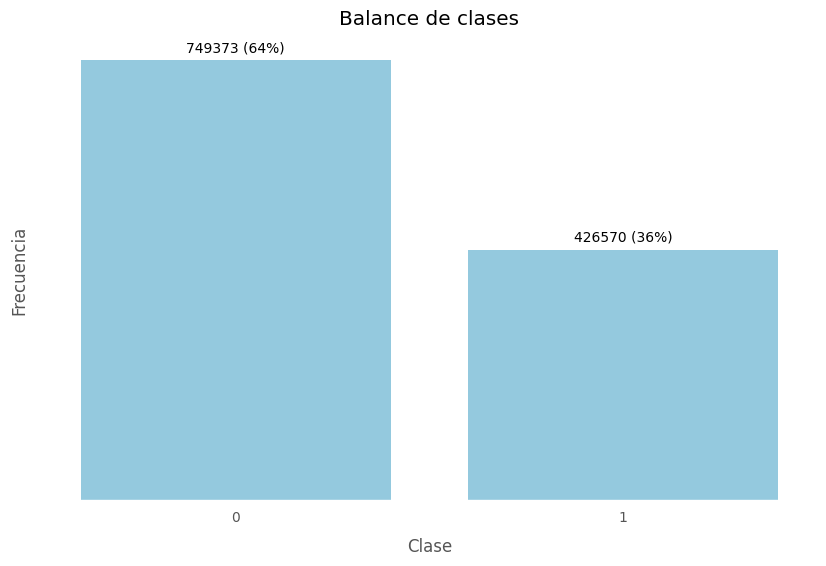

In [28]:
# Customized style
custom_style = {
    'axes.edgecolor': 'white',  # Axis layout color
    'axes.facecolor': 'white',  # Axias face color
    'grid.color': 'white',   # Grid lines color
}

plt.style.use('ggplot')  # Use ggplot as base
plt.rcParams.update(custom_style)  # Apply syle

# Gráfica de barras con seaborn
plt.figure(figsize=(10, 6)) # Tamaño de la figura
ax = sns.countplot(data=df_converted, x='CLASIFICACION_FINAL', color='skyblue') # Gráfica de barras
plt.title('Balance de clases', pad=10) # Título del gráfico
plt.xlabel('Clase', labelpad=10) # Etiqueta del eje x
plt.ylabel('Frecuencia', labelpad=10) # Etiqueta del eje y

# Desactivar las marcas en el eje x
plt.tick_params(axis='x', which='both', bottom=False, top=False)

# Eliminar los valores del eje y
ax.set_yticks([])

# Anotar los valores de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())} ({round(p.get_height()/len(df_converted) *100)}%)', (p.get_x() + p.get_width() / 2., p.get_height() + 10000), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show() # Mostrar gráfico


Se debe de tomar en cuenta el desbalance de los datos a la hora de seleccionar el modelo y el algoritmo de aprendizaje. 

### Random Forest

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = df_converted.drop('CLASIFICACION_FINAL', axis=1)  # Características
y = df_converted['CLASIFICACION_FINAL']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el clasificador de Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_classifier.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

# Evaluar el modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nPrecisión del modelo:", accuracy_score(y_test, y_pred))

Matriz de confusión:
[[149410      0]
 [     0  85779]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    149410
           1       1.00      1.00      1.00     85779

    accuracy                           1.00    235189
   macro avg       1.00      1.00      1.00    235189
weighted avg       1.00      1.00      1.00    235189


Precisión del modelo: 1.0


In [31]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = df_converted.drop('CLASIFICACION_FINAL', axis=1)  # Características
y = df_converted['CLASIFICACION_FINAL']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el clasificador de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Definir la cuadrícula de hiperparámetros a buscar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en cada hoja del árbol
}

# Inicializar la búsqueda de hiperparámetros utilizando validación cruzada de 5 pliegues
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Entrenar el modelo utilizando la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
best_rf_classifier = grid_search.best_estimator_

# Predecir en el conjunto de prueba con el mejor modelo
y_pred = best_rf_classifier.predict(X_test)

# Evaluar el modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nPrecisión del modelo:", accuracy_score(y_test, y_pred))
